### Введение

Этот ноутбук используется для генерации признаков с помощью библиотеки tsfresh без разделения датасета. Последующее обучение модели состоит из следующих этапов:  
* обучение модели на всех сгенерированных признаках и выбор важных признаков; 
* повторное обучение модели с использованием только наиболее важных признаков; 
* поиск наилучших гиперпараметров с помощью библиотеки optuna; 
* финальное обучение модели с использованием лучших гиперпараметров на датасете с наиболее важными признаками. 
Ноутбук состоит из следующих частей: предобработка данных, генерация признаков, обучение модели, предсказание. В конце каждой части мы сформулировали промежуточные итоги.

In [23]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import optuna
import warnings #для игнорирования предупреждений об ошибках
warnings.filterwarnings("ignore")
import re #для работы с регулярными выражениями
# импортируем необходимые функции из библиотеки для генерации признаков
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

### Предобработка

In [24]:
#читаем файл
sales = pd.read_csv('sales_df_train.csv')
sales.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


In [25]:
sales.shape

(883015, 8)

In [26]:
#удалим 2 неактивных магазина
sales = sales[~sales['st_id'].isin(['1aa057313c28fa4a40c5bc084b11d276', '62f91ce9b820a491ee78c108636db089'])]
sales.shape

(882286, 8)

In [27]:
#удалим случаи где продажи в штуках ноль, а в рублях нет и наоборот.
sales = sales[((sales['pr_sales_in_units'] != 0) & (sales['pr_sales_in_rub'] != 0)) | ((sales['pr_sales_in_units'] == 0) & (sales['pr_sales_in_rub'] == 0))]
sales.shape

(815404, 8)

In [28]:
#удалим отрицательные продажи
sales = sales[(sales['pr_sales_in_rub'] >= 0) & (sales['pr_sales_in_units'] >= 0) & (sales['pr_promo_sales_in_rub'] >= 0) & (sales['pr_promo_sales_in_units'] >= 0)]
sales.shape

(815334, 8)

In [29]:
#создадим столбец пары магазин-товар
sales['store_item'] = sales['st_id'].str.cat(sales['pr_sku_id'], sep='-')
sales['store_item'].nunique()

6130

In [30]:
#переведем даты в формат даты
sales['date'] = pd.to_datetime(sales['date']).dt.normalize()

In [31]:
sales.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,store_item
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0,c81e728d9d4c2f636f067f89cc14862c-c7b711619071c...
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0,42a0e188f5033bc65bf8d78622277c4e-68f441429e73d...
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0,1ecfb463472ec9115b10c292ef8bc986-22988026fe85f...
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0,16a5cdae362b8d27a1d8f8c7b78b4330-e6fc24ca84633...
5,42a0e188f5033bc65bf8d78622277c4e,3474f0e025c7deb7e127a35763bc5512,2022-11-03,0,3.0,0.0,123.0,0.0,42a0e188f5033bc65bf8d78622277c4e-3474f0e025c7d...


In [32]:
#соединим вместе строки с промо и без
oneline = sales.groupby(['store_item', 'date'])[['pr_sales_type_id', 'pr_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_units', 'pr_promo_sales_in_rub']].sum()
oneline = oneline.reset_index()
oneline.shape

(661192, 7)

In [33]:
#создадим датафрейм с отдельными товаром и магазином
separate_product_store = sales[['pr_sku_id', 'st_id', 'store_item']].drop_duplicates(subset='store_item')
df_fin = oneline.merge(separate_product_store, how='left', on='store_item')
df_fin.shape

(661192, 9)

Шаги предобработки:

* удалили два неактивных магазина. Для них не требуется прогноз, и данных по ним мало - едва ли они серьезно на что-то повлияют

* удалили любые отрицательные продажи. Вероятно, это возвраты товаров, не превысившие в этот день продажи. Возвраты не характеризуют спрос, являющийся нашей целью в данной работе

* удалили случаи, когда продажи в штуках равны нулю, а в рублях нет. Мы полагаем, что это связано с округлением. Все данные в датасете округлены до целых. Если в день было продано менее 0.5 кг весового товара, он округлится до нуля, при этом продажи в рублях ненулевые. Эту гипотезу подтверждает то, что у всех таких товаров один и тот же тип (кг/штуки). Это соответствует цели исследования: продажи менее единицы отражают спрос, близкий к нулю

* удалили случаи, когда продажи в рублях нулевые, а в штуках нет. Это либо ошибки системы, либо покупатель по какой-то акции получил товар бесплатно, что в обоих случаях не отражает реальный спрос

* объединили продажи одного товара в одном магазине в один день по промо и без в одну строку

### Инженерия признаков

In [13]:
#разделим датасет на трейновую и валидационную выборки
end_train = df_fin['date'].max() - pd.Timedelta(days=14)
train = df_fin[df_fin['date'] <= end_train]
valid = df_fin[df_fin['date'] > end_train]

In [14]:
train.shape

(633735, 9)

In [15]:
valid.head()

,store_item,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_units,pr_promo_sales_in_rub,pr_sku_id,st_id
38,16a5cdae362b8d27a1d8f8c7b78b4330-0045ebdb1069f...,2023-07-13,0,1.0,81.0,0.0,0.0,0045ebdb1069ff4b3dd3efe628c39cd3,16a5cdae362b8d27a1d8f8c7b78b4330
39,16a5cdae362b8d27a1d8f8c7b78b4330-0045ebdb1069f...,2023-07-14,0,2.0,153.0,0.0,0.0,0045ebdb1069ff4b3dd3efe628c39cd3,16a5cdae362b8d27a1d8f8c7b78b4330
40,16a5cdae362b8d27a1d8f8c7b78b4330-0045ebdb1069f...,2023-07-15,0,2.0,155.0,0.0,0.0,0045ebdb1069ff4b3dd3efe628c39cd3,16a5cdae362b8d27a1d8f8c7b78b4330
41,16a5cdae362b8d27a1d8f8c7b78b4330-0045ebdb1069f...,2023-07-16,0,2.0,156.0,0.0,0.0,0045ebdb1069ff4b3dd3efe628c39cd3,16a5cdae362b8d27a1d8f8c7b78b4330
42,16a5cdae362b8d27a1d8f8c7b78b4330-0045ebdb1069f...,2023-07-18,0,1.0,80.0,0.0,0.0,0045ebdb1069ff4b3dd3efe628c39cd3,16a5cdae362b8d27a1d8f8c7b78b4330


In [16]:
#подготовим датасет для генерации признаков с помощью tsfresh
train_fresh = train[['pr_sales_in_units','pr_sku_id']]
train_fresh.set_axis([0,1], axis='columns',inplace= True)
train_fresh.head()

,0,1
0,1.0,0376a60d9a7ce7965beddc4815588697
1,1.0,0376a60d9a7ce7965beddc4815588697
2,1.0,0376a60d9a7ce7965beddc4815588697
3,1.0,0376a60d9a7ce7965beddc4815588697
4,1.0,0376a60d9a7ce7965beddc4815588697


Извлекаем признаки при помощи extract_features, указав в качестве параметров для извлечения наш датафрейм. Также укажем параметр для impute_function, передав туда функцию impute, импортированную выше из tsfresh.utilities.dataframe_functions. Эта функция автоматически заполнит все пропуски в получившемся датасете (если они там внезапно появятся).

In [17]:
#сгенерируем признаки с помощью библиотеки tsfresh
#settings_comprehensive = settings.ComprehensiveFCParameters()
settings_efficient = settings.EfficientFCParameters()
X = extract_features(train_fresh, column_id=1, impute_function=impute, default_fc_parameters=settings_efficient)
print(X.shape)

Feature Extraction: 100%|██████████| 20/20 [02:19<00:00,  6.96s/it]


(1937, 783)


In [18]:
X_1=X.copy()

In [67]:
#посмотрим на признаки
#settings_efficient

In [20]:
# изменим названия колонок чтобы модель не выдавала ошибку о невозможности работы с JSON
import re
new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X_1.columns}
new_n_list = list(new_names.values())
# изменим названия для признаков появляющихся более одного раза
new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
X_1 = X_1.rename(columns=new_names)
X_1.head()

,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,0__median,...,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_00,0__matrix_profile__feature_min__threshold_098,0__matrix_profile__feature_max__threshold_098,0__matrix_profile__feature_mean__threshold_098,0__matrix_profile__feature_median__threshold_098,0__matrix_profile__feature_25__threshold_098,0__matrix_profile__feature_75__threshold_098,0__mean_n_absolute_max__number_of_maxima_7
002c3a40ac50dc870f1ff386f11f5bae,0.0,0.0,0.0,0.0,1.0,1.0,1.226891,0.000000,0.000000,1.0,...,4.118065,4.517693,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,7.000000
005c52de11abaf8e0a9714b24415ce34,0.0,1.0,1.0,1.0,19.0,41.0,0.777778,0.111111,0.000000,2.0,...,1.609438,1.386294,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,2.285714
0063fbd948a3d7368ba9d97739bfe2cc,0.0,0.0,1.0,1.0,7.0,9.0,0.200000,-0.200000,0.125000,1.0,...,-0.000000,4.517693,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,7.000000
00661699f543753ec7e911a64b9fd2f6,1.0,0.0,1.0,1.0,3294.0,10644.0,1.151324,0.000000,-0.000315,2.0,...,5.149643,6.095022,0.0,1.041200,3.760538,2.749533,2.813132,2.492434,3.078263,14.571429
0094042bfeae507dc7f62acc8e5ed03a,1.0,0.0,1.0,1.0,12055.0,239525.0,5.665584,-0.003247,-0.001624,5.0,...,5.997863,6.948455,0.0,1.125677,3.561726,2.212140,2.206053,1.893733,2.535443,71.857143


In [21]:
#вернем столбец с индексом товара
X_1.reset_index(inplace= True)
X_1= X_1.rename(columns={'index': 'pr_sku_id'})
X_1.head()

,pr_sku_id,0__variance_larger_than_standard_deviation,0__has_duplicate_max,0__has_duplicate_min,0__has_duplicate,0__sum_values,0__abs_energy,0__mean_abs_change,0__mean_change,0__mean_second_derivative_central,...,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_00,0__matrix_profile__feature_min__threshold_098,0__matrix_profile__feature_max__threshold_098,0__matrix_profile__feature_mean__threshold_098,0__matrix_profile__feature_median__threshold_098,0__matrix_profile__feature_25__threshold_098,0__matrix_profile__feature_75__threshold_098,0__mean_n_absolute_max__number_of_maxima_7
0,002c3a40ac50dc870f1ff386f11f5bae,0.0,0.0,0.0,0.0,1.0,1.0,1.226891,0.000000,0.000000,...,4.118065,4.517693,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,7.000000
1,005c52de11abaf8e0a9714b24415ce34,0.0,1.0,1.0,1.0,19.0,41.0,0.777778,0.111111,0.000000,...,1.609438,1.386294,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,2.285714
2,0063fbd948a3d7368ba9d97739bfe2cc,0.0,0.0,1.0,1.0,7.0,9.0,0.200000,-0.200000,0.125000,...,-0.000000,4.517693,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,7.000000
3,00661699f543753ec7e911a64b9fd2f6,1.0,0.0,1.0,1.0,3294.0,10644.0,1.151324,0.000000,-0.000315,...,5.149643,6.095022,0.0,1.041200,3.760538,2.749533,2.813132,2.492434,3.078263,14.571429
4,0094042bfeae507dc7f62acc8e5ed03a,1.0,0.0,1.0,1.0,12055.0,239525.0,5.665584,-0.003247,-0.001624,...,5.997863,6.948455,0.0,1.125677,3.561726,2.212140,2.206053,1.893733,2.535443,71.857143


In [22]:
#объединим датасет для трейна со сгенерированными признаками
df_fresh = train.merge(X_1, how='left', on='pr_sku_id')
df_fresh.sample(10)

,store_item,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_units,pr_promo_sales_in_rub,pr_sku_id,st_id,0__variance_larger_than_standard_deviation,...,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_00,0__matrix_profile__feature_min__threshold_098,0__matrix_profile__feature_max__threshold_098,0__matrix_profile__feature_mean__threshold_098,0__matrix_profile__feature_median__threshold_098,0__matrix_profile__feature_25__threshold_098,0__matrix_profile__feature_75__threshold_098,0__mean_n_absolute_max__number_of_maxima_7
549869,f7e6c85504ce6e82442c770f7c8606f0-f5a455e5fea83...,2023-04-30,0,7.0,1504.0,0.0,0.0,f5a455e5fea834c85429331d934c40fa,f7e6c85504ce6e82442c770f7c8606f0,1.0,...,5.256931,5.774899,0.0,1.371259,3.650418,2.781002,2.825124,2.558757,3.031294,15.142857
98734,16a5cdae362b8d27a1d8f8c7b78b4330-e4522fed8db6c...,2022-11-03,1,8.0,256.0,8.0,256.0,e4522fed8db6c62127eedea2fe1634bd,16a5cdae362b8d27a1d8f8c7b78b4330,1.0,...,6.066606,7.032378,0.0,0.783917,2.767456,1.826123,1.835705,1.608596,2.066756,24.714286
368930,c81e728d9d4c2f636f067f89cc14862c-421b0ea70ab7f...,2022-08-23,0,3.0,846.0,0.0,0.0,421b0ea70ab7fd681ae63a8f12695199,c81e728d9d4c2f636f067f89cc14862c,1.0,...,5.905870,6.913611,0.0,0.871789,3.918485,2.650139,2.747313,2.371691,3.041922,30.285714
455769,c81e728d9d4c2f636f067f89cc14862c-fbc15b8efc0a6...,2022-10-15,0,1.0,328.0,0.0,0.0,fbc15b8efc0a6d6eaae607c074816644,c81e728d9d4c2f636f067f89cc14862c,1.0,...,4.886952,5.366552,0.0,1.049282,3.079962,2.021021,1.993005,1.708964,2.385310,9.857143
281095,6364d3f0f495b6ab9dcf8d3b5c6e0b01-58ebafabd92e2...,2022-10-04,1,12.0,2174.0,12.0,2174.0,58ebafabd92e2e3a80d86b7bb7e88eda,6364d3f0f495b6ab9dcf8d3b5c6e0b01,1.0,...,6.073364,7.102277,0.0,0.803297,2.691909,1.715736,1.718739,1.476336,1.958279,44.428571
594698,fa7cdfad1a5aaf8370ebeda47a1ff1c3-83913200ee37a...,2022-12-11,1,3.0,61.0,3.0,61.0,83913200ee37a50f3922fabbc9826991,fa7cdfad1a5aaf8370ebeda47a1ff1c3,1.0,...,5.104965,5.729606,0.0,1.003967,2.800027,2.007729,2.003771,1.783034,2.261701,10.714286
146224,42a0e188f5033bc65bf8d78622277c4e-0a2090e24b6ae...,2023-05-27,1,21.0,2357.0,21.0,2357.0,0a2090e24b6ae62b0b0fcaa67a72b5a0,42a0e188f5033bc65bf8d78622277c4e,1.0,...,6.161694,7.044456,0.0,1.267525,4.735739,3.056530,3.117475,2.487642,3.655997,285.714286
95108,16a5cdae362b8d27a1d8f8c7b78b4330-db54d9d5b110c...,2023-02-21,1,3.0,110.0,1.0,31.0,db54d9d5b110c3a457bf89559b6f89a6,16a5cdae362b8d27a1d8f8c7b78b4330,1.0,...,6.095526,7.166948,0.0,0.877723,3.037584,2.168946,2.199147,1.962893,2.406823,24.571429
83579,16a5cdae362b8d27a1d8f8c7b78b4330-c0e3f3bd815a8...,2022-12-24,1,96.0,12568.0,12.0,1420.0,c0e3f3bd815a862433bc3399c487926b,16a5cdae362b8d27a1d8f8c7b78b4330,1.0,...,5.829970,6.831229,0.0,0.857362,3.184264,1.769924,1.756635,1.458432,2.028374,298.142857
92628,16a5cdae362b8d27a1d8f8c7b78b4330-d5285a5b153c4...,2022-11-29,0,2.0,384.0,0.0,0.0,d5285a5b153c43fa0028b6fb6965a3f0,16a5cdae362b8d27a1d8f8c7b78b4330,1.0,...,5.300657,6.217393,0.0,2.927832,8.246211,4.694972,4.710358,4.270329,5.090830,11.857143


In [24]:
#объединим датасет для валидации со сгенерированными признаками
valid = valid.merge(X_1, how='left', on='pr_sku_id')
valid.sample(10)

,store_item,date,pr_sales_type_id,pr_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_units,pr_promo_sales_in_rub,pr_sku_id,st_id,0__variance_larger_than_standard_deviation,...,0__permutation_entropy__dimension_6__tau_1,0__permutation_entropy__dimension_7__tau_1,0__query_similarity_count__query_None__threshold_00,0__matrix_profile__feature_min__threshold_098,0__matrix_profile__feature_max__threshold_098,0__matrix_profile__feature_mean__threshold_098,0__matrix_profile__feature_median__threshold_098,0__matrix_profile__feature_25__threshold_098,0__matrix_profile__feature_75__threshold_098,0__mean_n_absolute_max__number_of_maxima_7
7923,42a0e188f5033bc65bf8d78622277c4e-5d560ea997068...,2023-07-11,1,18.0,2959.0,18.0,2959.0,5d560ea997068115892d2f0bd7cf91c3,42a0e188f5033bc65bf8d78622277c4e,1.0,...,5.879954,6.539219,0.0,0.737310,2.434406,1.509418,1.476208,1.290319,1.714986,52.000000
20539,f7e6c85504ce6e82442c770f7c8606f0-3cf7842c20744...,2023-07-17,0,3.0,802.0,0.0,0.0,3cf7842c207445d9456cecd7be03c53a,f7e6c85504ce6e82442c770f7c8606f0,1.0,...,5.117562,5.460299,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,12.714286
24315,fa7cdfad1a5aaf8370ebeda47a1ff1c3-3775e29ab7a50...,2023-07-16,1,1.0,118.0,1.0,118.0,3775e29ab7a50a69c73aad30f19661e4,fa7cdfad1a5aaf8370ebeda47a1ff1c3,1.0,...,5.059103,5.779819,0.0,2.744487,4.880339,3.963815,4.027777,3.689194,4.283165,7.857143
12271,6364d3f0f495b6ab9dcf8d3b5c6e0b01-5adfc37e8b1a7...,2023-07-18,1,5.0,91.0,5.0,91.0,5adfc37e8b1a7ab1549daeb6f4918426,6364d3f0f495b6ab9dcf8d3b5c6e0b01,1.0,...,6.271413,7.101185,0.0,0.724050,2.129216,1.485507,1.502871,1.307419,1.676382,68.285714
13404,6364d3f0f495b6ab9dcf8d3b5c6e0b01-9fafa622a1f0d...,2023-07-10,0,4.0,101.0,0.0,0.0,9fafa622a1f0dbc2bee82d3ac129ea6f,6364d3f0f495b6ab9dcf8d3b5c6e0b01,1.0,...,5.948156,6.725494,0.0,0.699083,2.228140,1.619874,1.634080,1.465828,1.794844,34.142857
17865,c81e728d9d4c2f636f067f89cc14862c-94126c3b19235...,2023-07-08,1,20.0,1796.0,20.0,1796.0,94126c3b192352d3da494487f5370e7d,c81e728d9d4c2f636f067f89cc14862c,1.0,...,5.758816,6.218521,0.0,1.196315,2.808050,1.841162,1.853015,1.616920,2.053003,46.714286
3213,16a5cdae362b8d27a1d8f8c7b78b4330-9cb1c6f7a2a51...,2023-07-06,1,12.0,618.0,6.0,299.0,9cb1c6f7a2a51376b49fc2a81a8fe192,16a5cdae362b8d27a1d8f8c7b78b4330,1.0,...,4.402170,4.454347,0.0,1.119978,3.339611,2.281013,2.296251,1.981655,2.569206,18.142857
25227,fa7cdfad1a5aaf8370ebeda47a1ff1c3-699dc7822b719...,2023-07-08,1,1.0,101.0,1.0,101.0,699dc7822b719137e8124b728ab45fa3,fa7cdfad1a5aaf8370ebeda47a1ff1c3,1.0,...,5.372800,6.223288,0.0,2.362329,6.633250,3.564487,3.616764,3.323821,3.865287,12.000000
19898,f7e6c85504ce6e82442c770f7c8606f0-0f152427918d2...,2023-07-18,0,2.0,86.0,0.0,0.0,0f152427918d29bb1081834c1d375a48,f7e6c85504ce6e82442c770f7c8606f0,1.0,...,5.880373,6.733020,0.0,0.795391,3.117291,2.260978,2.309863,2.089782,2.505391,44.000000
19025,c81e728d9d4c2f636f067f89cc14862c-db29fe8899be1...,2023-07-12,0,1.0,300.0,0.0,0.0,db29fe8899be1b4a7612f9941a24c24d,c81e728d9d4c2f636f067f89cc14862c,1.0,...,5.059235,5.429396,0.0,1.069495,2.730922,1.908070,1.929325,1.684950,2.162571,7.285714


In [44]:
# для второй итерации оставим только важные признаки и добавим календарные признаки в обучающем датасете
df_fresh = df_fresh[['pr_sales_in_units','date', 'store_item',
 'pr_sales_type_id',
 'pr_sku_id',
 'st_id',
 '0__abs_energy',
 '0__sum_values',
 '0__mean',
 '0__mean_abs_change',
 '0__mean_change',
 '0__variation_coefficient',
 '0__mean_second_derivative_central',
 '0__friedrich_coefficients__coeff_2__m_3__r_30',
 '0__length',
 '0__has_duplicate_min',
 '0__cwt_coefficients__coeff_14__w_2__widths_251020',
 '0__percentage_of_reoccurring_values_to_all_values',
 '0__skewness',
 '0__time_reversal_asymmetry_statistic__lag_1',
 '0__last_location_of_maximum',
 '0__time_reversal_asymmetry_statistic__lag_2']]

In [48]:
#добавим календарные признаки день недели, день месяца, неделя, месяц, время года для обучающего датасета
df_fresh['dow'] = df_fresh['date'].dt.dayofweek
df_fresh['day'] = df_fresh['date'].dt.day
df_fresh['week'] = df_fresh['date'].dt.isocalendar().week.astype('int32')
df_fresh['month'] = df_fresh['date'].dt.month
df_fresh['season'] = df_fresh['date'].dt.quarter  

In [46]:
# для второй итерации оставим только важные признаки и добавим календарные признаки в валидационном датасете
valid = valid[['pr_sales_in_units','date', 'store_item',
 'pr_sales_type_id',
 'pr_sku_id',
 'st_id',
 '0__abs_energy',
 '0__sum_values',
 '0__mean',
 '0__mean_abs_change',
 '0__mean_change',
 '0__variation_coefficient',
 '0__mean_second_derivative_central',
 '0__friedrich_coefficients__coeff_2__m_3__r_30',
 '0__length',
 '0__has_duplicate_min',
 '0__cwt_coefficients__coeff_14__w_2__widths_251020',
 '0__percentage_of_reoccurring_values_to_all_values',
 '0__skewness',
 '0__time_reversal_asymmetry_statistic__lag_1',
 '0__last_location_of_maximum',
 '0__time_reversal_asymmetry_statistic__lag_2']]

In [49]:
#добавим календарные признаки день недели, день месяца, неделя, месяц, время года для валидационного датасета
valid['dow'] = valid['date'].dt.dayofweek
valid['day'] = valid['date'].dt.day
valid['week'] = valid['date'].dt.isocalendar().week.astype('int32')
valid['month'] = valid['date'].dt.month
valid['season'] = valid['date'].dt.quarter  

In [72]:
#df_fresh.iloc[:,:30].info()

**Выводы по feature engineering:**
1. Разбит датасет на трейн и валидацию.
2. Получены 783 признака с помощью библиотеки tsfresh для каждого товара в отдельности.
3. Предполагается для первой итерации обучить модель на всех признаках и отсортировать их по важности, далее на второй итерации обучать модель только на топ20 признаках и добавить календарные.

### Обучение модели

#### Без кросс-валидации

Забегая вперед укажем, что кросс-валидация не показала значительного прироста метрики по сравнению с однократным обучением на всем датасете. Поэтому она представлена в п.4.2, но не используется в файле model.py.

In [35]:
# создадим функцию для вычисления метрики
def wape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [36]:
#создадим функцию для отрисовки важности признаков
def plotImp(model, X , num = 20, fig_size = (15, 5)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features importance')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

2023-07-04 00:00:00
(633735, 25) (27457, 25)
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 74.7118
[200]	valid_0's l2: 72.8378
[300]	valid_0's l2: 72.5862
[400]	valid_0's l2: 72.0209
[500]	valid_0's l2: 71.4632
[600]	valid_0's l2: 71.209
[700]	valid_0's l2: 70.8937
[800]	valid_0's l2: 70.7033
[900]	valid_0's l2: 70.6137
[1000]	valid_0's l2: 70.4348
[1100]	valid_0's l2: 70.4507
[1200]	valid_0's l2: 70.3183
[1300]	valid_0's l2: 70.4634
[1400]	valid_0's l2: 70.4408
Early stopping, best iteration is:
[1252]	valid_0's l2: 70.2655
LGBM WAPE: 0.42339581524648934


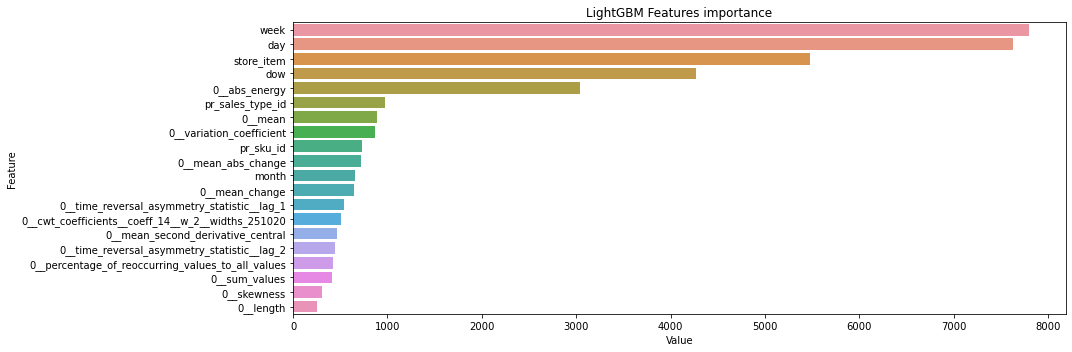

In [55]:
#обучим модель и посчитаем метрику
data=df_fresh
#cols_to_drop=['pr_sales_in_units', 'date', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']
cols_to_drop=['pr_sales_in_units', 'date']
cat_features=['store_item', 'pr_sku_id', 'st_id']

X_train = df_fresh.drop(cols_to_drop, axis=1)
y_train = df_fresh['pr_sales_in_units']
X_valid = valid.drop(cols_to_drop, axis=1)
y_valid = valid['pr_sales_in_units']

eval_set = [(X_valid, y_valid)]
print(end_train)
print(X_train.shape, X_valid.shape)
        
cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X_train[col] = pd.Categorical(X_train[col])
    X_valid[col] = pd.Categorical(X_valid[col])

lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, random_state=26)
lgbm_reg.fit(
                X_train, 
                y_train,        
                categorical_feature=cat_idx,
                eval_set=eval_set,
                early_stopping_rounds=200,
                verbose=100
            )
preds = lgbm_reg.predict(X_valid)
lgbm_wape = wape(y_valid, preds)
print(f"LGBM WAPE: {lgbm_wape}")

plotImp(lgbm_reg, X_train)

In [57]:
#сохраним модель
import pickle
pkl_filename = "fin_fresh_model_top20_feature_eff.pkl" 
with open(pkl_filename, 'wb') as file: 
    pickle.dump(lgbm_reg, file) 

In [56]:
#найдем список 20 лучших признаков
feature_imp = pd.DataFrame({'Value':lgbm_reg.feature_importances_,'Feature':X_train.columns})
feature_list=feature_imp.sort_values(by ='Value', ascending = False).head(20)['Feature'].to_list()
feature_list

['week',
 'day',
 'store_item',
 'dow',
 '0__abs_energy',
 'pr_sales_type_id',
 '0__mean',
 '0__variation_coefficient',
 'pr_sku_id',
 '0__mean_abs_change',
 'month',
 '0__mean_change',
 '0__time_reversal_asymmetry_statistic__lag_1',
 '0__cwt_coefficients__coeff_14__w_2__widths_251020',
 '0__mean_second_derivative_central',
 '0__time_reversal_asymmetry_statistic__lag_2',
 '0__percentage_of_reoccurring_values_to_all_values',
 '0__sum_values',
 '0__skewness',
 '0__length']

Результаты на датасете df_fin с 780 фичами сгенерированными EfficientFCParameters.<div>
        **Итерация 1.** <div>
* Фичи: Магазин-товар, магазин, флаг промо и то, что сгенерировал tsfresh (780+ фич).
* ВЭЙП: 0.4714141420531011
* Важное: 'store_item',
 'pr_sales_type_id',
 'pr_sku_id',
 'st_id',
 '0__abs_energy',
 '0__sum_values',
 '0__mean',
 '0__mean_abs_change',
 '0__mean_change',
 '0__variation_coefficient',
 '0__mean_second_derivative_central',
 '0__friedrich_coefficients__coeff_2__m_3__r_30',
 '0__length',
 '0__has_duplicate_min',
 '0__cwt_coefficients__coeff_14__w_2__widths_251020',
 '0__percentage_of_reoccurring_values_to_all_values',
 '0__skewness',
 '0__time_reversal_asymmetry_statistic__lag_1',
 '0__last_location_of_maximum',
 '0__time_reversal_asymmetry_statistic__lag_2' . <div>
    
**Итерация 2.** <div>
* Фичи: Важные фичи из первой итерации и календарные.
* ВЭЙП: 0.42339581524648934
* Важное: 'week',
 'day',
 'store_item',
 'dow',
 '0__abs_energy',
 'pr_sales_type_id',
 '0__mean',
 '0__variation_coefficient',
 'pr_sku_id',
 '0__mean_abs_change',
 'month',
 '0__mean_change',
 '0__time_reversal_asymmetry_statistic__lag_1',
 '0__cwt_coefficients__coeff_14__w_2__widths_251020',
 '0__mean_second_derivative_central',
 '0__time_reversal_asymmetry_statistic__lag_2',
 '0__percentage_of_reoccurring_values_to_all_values',
 '0__sum_values',
 '0__skewness',
 '0__length'. 

#### Оптимизация гиперпараметров модели

In [15]:
 #создадим функцию для подбора лучших гиперпараметров
def objective(trial, data=df_fresh, cols_to_drop=['pr_sales_in_units', 'date'], cat_features=['store_item', 'pr_sku_id', 'st_id', 'dow']):
    
    train_x = df_fresh.drop(cols_to_drop, axis=1)
    train_y = train['pr_sales_in_units']
    test_x = valid.drop(cols_to_drop, axis=1)
    test_y = valid['pr_sales_in_units']

    cat_idx = [train_x.columns.get_loc(col) for col in cat_features]

    for col in cat_features:
        train_x[col] = pd.Categorical(train_x[col])
        test_x[col] = pd.Categorical(test_x[col])

    param = {
        'metric': 'mae', 
        'random_state': 26,
        'n_estimators': 20000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 0.95, step=0.1)
    }
    model = lgbm.LGBMRegressor(**param)  
    
    model.fit(train_x,train_y,categorical_feature=cat_idx,eval_set=[(test_x,test_y)],early_stopping_rounds=100,verbose=500)
    
    preds = model.predict(test_x)

    trial.set_user_attr(key="best_booster", value=model)
    
    return wape(test_y, preds)

def callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key="best_booster", value=trial.user_attrs["best_booster"])


if __name__ == "__main__":
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=10), direction='minimize'
    )
    study.optimize(objective, n_trials=10, callbacks=[callback])
    best_model=study.user_attrs["best_booster"]

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

LGBM WAPE: 0.41411217901947295


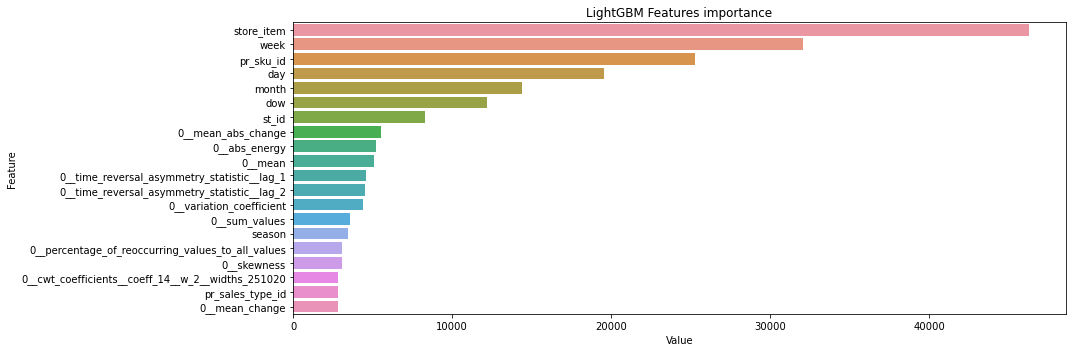

In [61]:
#обучим модель на лучших гиперпараметрах
data=df_fresh
cols_to_drop=['pr_sales_in_units', 'date']
cat_features=['store_item', 'pr_sku_id', 'st_id', 'dow']

X_train = df_fresh.drop(cols_to_drop, axis=1)
y_train = df_fresh['pr_sales_in_units']
X_valid = valid.drop(cols_to_drop, axis=1)
y_valid = valid['pr_sales_in_units']

cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

for col in cat_features:
    X_train[col] = pd.Categorical(X_train[col])
    X_valid[col] = pd.Categorical(X_valid[col])

lgbm_reg = best_model
preds = lgbm_reg.predict(X_valid)
lgbm_wape = wape(y_valid, preds)
print(f"LGBM WAPE: {lgbm_wape}")

plotImp(lgbm_reg, X_train)

In [62]:
# #сохраним модель с лучшими гиперпараметрами
# import pickle
# pkl_filename = "fin_fresh_optuna_top20_feature_eff.pkl" 
# with open(pkl_filename, 'wb') as file: 
#     pickle.dump(lgbm_reg, file) 

Здесь выписаны лучшие гиперпараметры: <div>
Best trial: {'reg_alpha': 0.00949821637813171, 'reg_lambda': 0.33595813853679407, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 100, 'num_leaves': 338, 'min_child_samples': 208, 'feature_fraction': 0.5}

В результате оптимизации гиперпараметров получен прирост метрики в 1%.

#### Обучение с кросс-валидацией

Возьмем лучшие гиперпараметры и обучим на них модель с кросс-валидацией. Глубину деревьев я увеличил до 200, т.к. отметил, что лучшей глубиной была выбрана максимальная из 3х предложенных значений. 

In [37]:
#создадим функцию для кросс-валидации
def lgbm_cross_val(cat_features, cols_to_drop, df=df_fin, h=14, cv=5):
    wapes = []
    for i in range(cv):
        end_train = df['date'].max() - pd.Timedelta(days=h*(i+1))
        end_valid = df['date'].max() - pd.Timedelta(days=h*i)
        train = df[df['date'] <= end_train]
        valid = df[(df['date'] > end_train) & (df['date'] <= end_valid)]

        train_fresh = df[df['date'] <= end_train][['pr_sales_in_units','pr_sku_id']]
        train_fresh = train_fresh.set_axis([0,1], axis='columns')

        settings_efficient = settings.EfficientFCParameters()

        X = extract_features(train_fresh, column_id=1, impute_function=impute, default_fc_parameters=settings_efficient)

        # Change columns names ([LightGBM] Do not support special JSON characters in feature name.)
        new_names = {col: re.sub(r'[^A-Za-z0-9_]+', '', col) for col in X.columns}
        new_n_list = list(new_names.values())
        # [LightGBM] Feature appears more than one time.
        new_names = {col: f'{new_col}_{i}' if new_col in new_n_list[:i] else new_col for i, (col, new_col) in enumerate(new_names.items())}
        X = X.rename(columns=new_names)

        X.reset_index(inplace= True)
        X = X.rename(columns={'index': 'pr_sku_id'})

        selected_features = ['pr_sku_id',
                            '0__abs_energy',
                            '0__sum_values',
                            '0__mean',
                            '0__mean_abs_change',
                            '0__mean_change',
                            '0__variation_coefficient',
                            '0__mean_second_derivative_central',
                            '0__friedrich_coefficients__coeff_2__m_3__r_30',
                            '0__length',
                            '0__has_duplicate_min',
                            '0__cwt_coefficients__coeff_14__w_2__widths_251020',
                            '0__percentage_of_reoccurring_values_to_all_values',
                            '0__skewness',
                            '0__time_reversal_asymmetry_statistic__lag_1',
                            '0__last_location_of_maximum',
                            '0__time_reversal_asymmetry_statistic__lag_2']

        train = train.merge(X[selected_features], how='left', on='pr_sku_id')
        valid = valid.merge(X[selected_features], how='left', on='pr_sku_id')

        X_train = train.drop(cols_to_drop, axis=1)
        y_train = train['pr_sales_in_units']
        X_valid = valid.drop(cols_to_drop, axis=1)
        y_valid = valid['pr_sales_in_units']

        eval_set = [(X_valid, y_valid)]

        cat_idx = [X_train.columns.get_loc(col) for col in cat_features]

        for col in cat_features:
            X_train[col] = pd.Categorical(X_train[col])
            X_valid[col] = pd.Categorical(X_valid[col])


        lgbm_reg = lgbm.LGBMRegressor(n_estimators=10000, reg_alpha= 0.00949821637813171, reg_lambda= 0.33595813853679407, 
                                      colsample_bytree= 0.5, subsample= 0.7, learning_rate= 0.02, max_depth= 200, 
                                      num_leaves= 338, min_child_samples= 208, feature_fraction= 0.5, random_state=26)
        lgbm_reg.fit(
                X_train, 
                y_train,        
                categorical_feature=cat_idx,
                eval_set=eval_set,
                early_stopping_rounds=200,
                verbose=100 
            )

        preds = lgbm_reg.predict(X_valid)
        lgbm_wape = wape(y_valid, preds)
        
        plot_df = pd.DataFrame({'date': pd.date_range(start=(end_train+pd.Timedelta(days=1)), end=end_valid), 'y_true': y_valid[:h], 'y_pred': preds[:h]})
        
        fig, ax = plt.subplots(figsize=(12, 3))
        g = sns.lineplot(data=plot_df)
        plt.title(f'CV step {i+1}')
        plt.show()        
        
        print(f"LGBM CV step {i+1} WAPE: {lgbm_wape}")
        wapes.append(lgbm_wape)

        
    plotImp(lgbm_reg, X_train)

    return(wapes)

Feature Extraction: 100%|██████████| 20/20 [02:16<00:00,  6.82s/it]


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 103.766
[200]	valid_0's l2: 97.0692
[300]	valid_0's l2: 96.2724
[400]	valid_0's l2: 96.0962
[500]	valid_0's l2: 95.8656
[600]	valid_0's l2: 95.7987
[700]	valid_0's l2: 95.799
[800]	valid_0's l2: 95.763
[900]	valid_0's l2: 95.7682
[1000]	valid_0's l2: 95.7386
[1100]	valid_0's l2: 95.7307
[1200]	valid_0's l2: 95.7091
[1300]	valid_0's l2: 95.6965
[1400]	valid_0's l2: 95.7136
Early stopping, best iteration is:
[1269]	valid_0's l2: 95.69


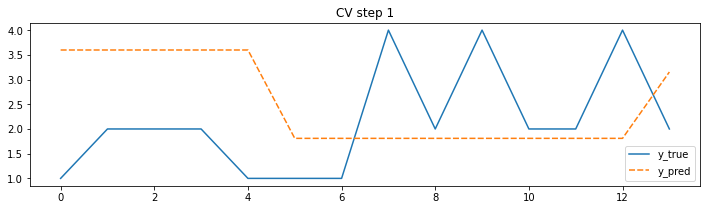

LGBM CV step 1 WAPE: 0.47054565267370385


Feature Extraction: 100%|██████████| 20/20 [02:13<00:00,  6.66s/it]


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 68.5123
[200]	valid_0's l2: 64.6719
[300]	valid_0's l2: 64.5491
[400]	valid_0's l2: 64.5592
Early stopping, best iteration is:
[260]	valid_0's l2: 64.5138


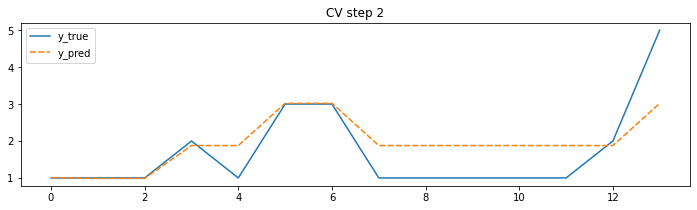

LGBM CV step 2 WAPE: 0.4563308772296266


Feature Extraction: 100%|██████████| 20/20 [02:07<00:00,  6.39s/it]


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 120.865
[200]	valid_0's l2: 114.357
[300]	valid_0's l2: 113.406
[400]	valid_0's l2: 113.146
[500]	valid_0's l2: 113.018
[600]	valid_0's l2: 113.005
[700]	valid_0's l2: 113.007
[800]	valid_0's l2: 112.998
Early stopping, best iteration is:
[636]	valid_0's l2: 112.988


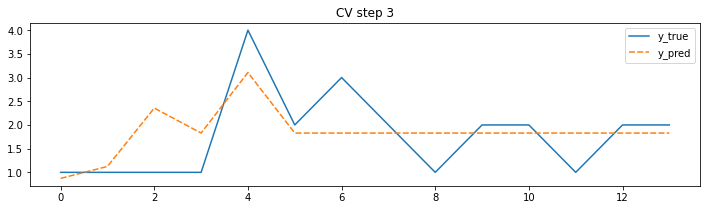

LGBM CV step 3 WAPE: 0.48837194268660455


Feature Extraction: 100%|██████████| 20/20 [01:59<00:00,  5.98s/it]


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 93.1087
[200]	valid_0's l2: 89.6535
[300]	valid_0's l2: 89.6458
[400]	valid_0's l2: 89.6929
Early stopping, best iteration is:
[250]	valid_0's l2: 89.6127


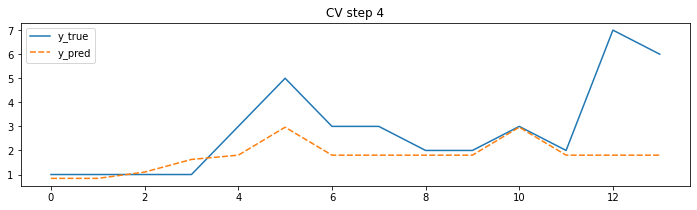

LGBM CV step 4 WAPE: 0.4819445302604781


Feature Extraction: 100%|██████████| 20/20 [01:53<00:00,  5.67s/it]


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=0.5 will be ignored. Current value: feature_fraction=0.5
Training until validation scores don't improve for 200 rounds
[100]	valid_0's l2: 116.879
[200]	valid_0's l2: 115.132
[300]	valid_0's l2: 115.511
Early stopping, best iteration is:
[183]	valid_0's l2: 114.961


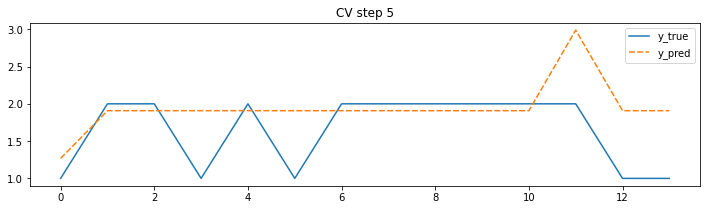

LGBM CV step 5 WAPE: 0.49273411246745674


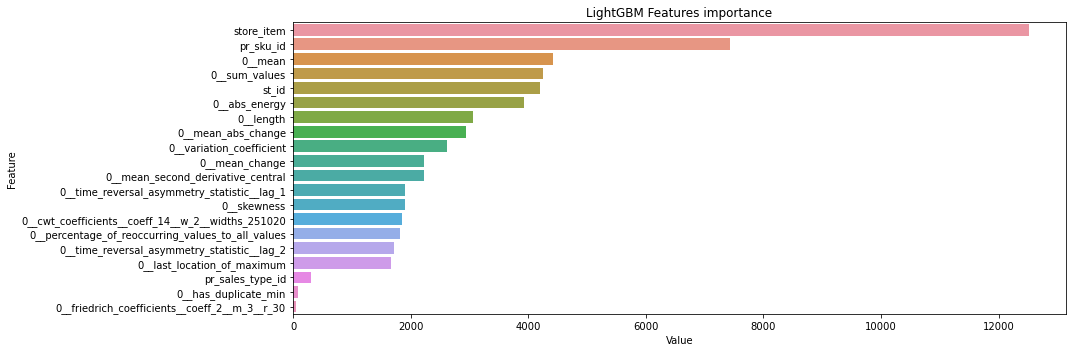

In [38]:
lgbm_wapes = lgbm_cross_val(df=df_fin, cat_features=['store_item', 'pr_sku_id', 'st_id'], 
                                            cols_to_drop=['pr_sales_in_units', 'date', 'pr_promo_sales_in_units',\
                                                          'pr_sales_in_rub', 'pr_promo_sales_in_rub'])

In [39]:
#выведем среднюю метрику по шагам кросс-валидации
print(f'LGBM mean WAPE = {np.mean(lgbm_wapes)}')

LGBM mean WAPE = 0.477985423063574


Применение кросс-валидации не показывает прироста метрики.

Здесь сохраняется та же логика кросс-валидации, которую мы применяли для модели c лагами: мы выделили в качестве валидационной выборки последние 14 дней, оставив все предшествующие данные в обучающей выборке. Для второго фолда кросс-валидации мы сдвинули валидационную выборку на две недели раньше, тем самым на 14 дней сократив обучающую. Таким образом мы в цикле последовательно формируем 5 фолдов кросс-валидации, обучаем на хронологически первых данных градиентный бустинг, валидируем его на последних 14 днях и оцениваем важность признаков в порядке от наиболее к наименее важным. 

Для сравнения приведем результаты обучения модели на датасете с применением лагов. 

Результаты с лагами и MA.<div>
Итерация 1

* Фичи: товар, магазин, 21 лаг (Тлаг)
* ВЭЙП: 0.5387446485520166
* Важное: товар, Тлаг 1, магазин, Тлаги 14, 7, 2, 6, 12, 13, 5, 9

Итерация 2

* Фичи: товар, магазин, 21 лаг (Тлаг), 21 лаг (Млаг)
* ВЭЙП: 0.542979568453861
* Важное: товар, Тлаги 1, 14, 7, магазин, Тлаг 6, Млаги 6, 7, 13, 14
* Вывод: стало хуже. Пока оставим магазинные лаги, но когда фичей будет больше, попробуем их убрать

Итерация 3

* Фичи: товар, магазин, 21 лаг (Тлаг), 21 лаг (Млаг), календарные
* ВЭЙП: 0.5372880913031014
* Важное: товар, Тлаги 1, 14, магазин, день недели, Млаг 7, Тлаги 2, 7, Млаг 6, Тлаг 6, Млаг 13
* Вывод: метрика немного улучшилась. Календарные фичи нужны

Сравнение показывает, что обучение на датасете с признаками сгенерированными библиотекой tsfresh дает лучшую метрику wape в сравнении с обучением на датасете с лагами. 

### **Выводы по обучению моделей с генерацией признаков с помощью tsfresh:** 

1. Оптимизация гиперпараметров дает прирост метрики на 1%. 
2. Применение кросс-валидации не показывает прироста метрики.
3. Сравнение моделей обученных на признаках сгенерированных с помощью tsfresh и на лаговых признаках указывает на преимущество применения библиотеки tsfresh.

### Что можно еще сделать

* заполнить нулями значения в пропущенных датах.

* попробовать другие алгоритмы ML, кроме градиентного бустинга

* использовать модели типа Аримы/Профета для прогноза цены вместо заглушки

* если возможно, то генерировать признаки библиотекой tsfresh на датасете включающем дату